In [923]:
import os
import pandas as pd
import seaborn as sb
import scipy.stats as stats
import numpy as np
import calendar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline

sb.set_style('whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [924]:
str_default_dir = 'D:\\Data\\GB305'

df_raw = pd.read_excel(f'{str_default_dir}\\RawData_20220316.xlsx', engine='openpyxl')
df_raw

,검사일자,검사시각,I/M작업월,I/M배치,작업특이사항,투입수량,불량수량,불량률,C/T관련불량\n(결점수),H/D관련불량\n(결점수),...,CT업체명,CT금형번호,CT배치-L,CT배치-R,HD업체명,HD금형번호,HD배치-L,HD배치-R,ERP 입력사항,측정유무
0,2021-12-03,01:19:39,21년12월,N21C020051,NaN,19197,4554,0.237225,0.230505,0.004167,...,미경,P03,1221C01006,1221C01003,성평,#2,2321B19108,2321B19092,NaN,1.0
1,2021-12-03,03:31:22,21년12월,N21C030004,NaN,19745,371,0.018790,0.002026,0.001418,...,LSM,P02,P21C020070,P21C020089,성평,#2,2321B19108,2321B19092,NaN,1.0
2,2021-12-03,06:26:15,21년12월,N21C030010,NaN,19787,1486,0.075100,0.065396,0.007581,...,미경,P03,1221C01004,1221C01001,성평,#2,2321B19101,2321B19085,NaN,NaN
3,2021-12-03,09:19:58,21년12월,N21C030013,NaN,19505,3668,0.188054,0.064650,0.004563,...,LSM,P02,P21C020104,P21C020125,성평,#2,2321B19107,2321B19091,NaN,1.0
4,2021-12-03,08:04:33,21년12월,N21C030014,NaN,19602,1173,0.059841,0.007295,0.000765,...,성평,P01,2321C02181,2321C02178,성평,#2,2321B19101,2321B19085,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,2022-02-28,04:56:37,22년02월,N222284002,NaN,19455,552,0.028373,0.001131,0.019481,...,미경,P03,1222129011,1222208001,성평,#1,2322221122,2322221108,NaN,NaN
898,2022-02-28,10:15:41,22년02월,N222284006,NaN,19969,397,0.019881,0.003956,0.006009,...,LSM,P01,P222151093,P222161038,성평,#1,2322221121,2322221105,NaN,NaN
899,2022-02-28,11:46:08,22년02월,N222281009,NaN,19451,3403,0.174952,0.003804,0.103182,...,미경,P03,1222113050,1222113045,성평,#2,2322124134,2322124122,C H/D 파손,NaN
900,2022-02-28,15:38:16,22년02월,N222285008,NaN,19891,1457,0.073249,0.055201,0.002011,...,미경,P03,1222130006,1222129002,성평,#1,2322221132,2322221116,NaN,NaN


In [925]:
start_year = df_raw['검사일자'].min().year
start_month = df_raw['검사일자'].min().month

end_year = df_raw['검사일자'].max().year
end_month = df_raw['검사일자'].max().month

list_df = []
list_str_date = []
month = start_month
for year in range(start_year, end_year + 1):
    while True:
        print(year, month)
        last_day = calendar.monthrange(year, month)[1]

        str_start_date = f'{year}-{month:02d}-01'
        str_end_date = f'{year}-{month:02d}-{last_day}'

        list_df.append(df_raw[(df_raw['검사일자'] >= str_start_date) & (df_raw['검사일자'] <= str_end_date)])
        list_str_date.append(f'{year}{month:02d}')

        if year == end_year and month == end_month:
            break

        month += 1
        if month > 12:
            month = 1
            break

list_df.append(df_raw)
list_str_date.append('total')

2021 12
2022 1
2022 2


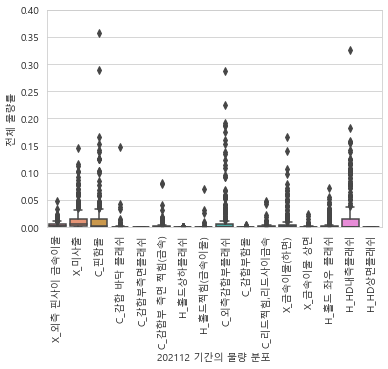

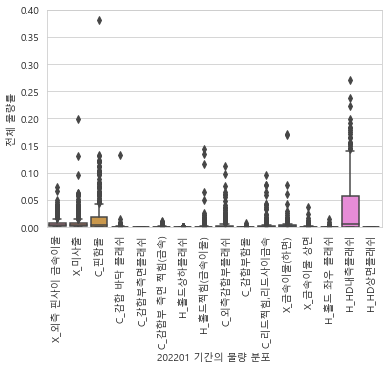

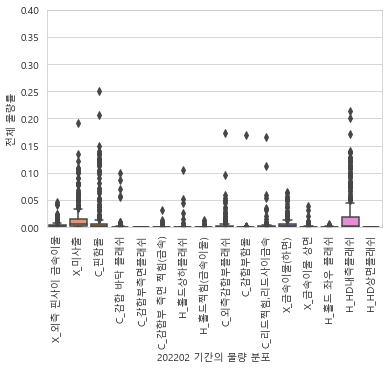

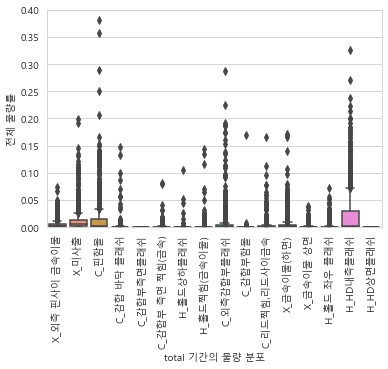

In [926]:
str_start_ng = 'X_외측 핀사이 금속이물'
str_end_ng = 'H_HD상면플래쉬'

n_start_ng = list(df_raw.columns).index(str_start_ng)
n_end_ng = list(df_raw.columns).index(str_end_ng)
idx_ng_rate = range(n_start_ng, n_end_ng + 1)

for _df, str_date in zip(list_df, list_str_date):
    fig = plt.figure()
    sb.boxplot(data=_df[_df.columns[idx_ng_rate]])
    plt.xticks(rotation=90)
    plt.xlabel(f'{str_date} 기간의 불량 분포')
    plt.ylabel('전체 불량률')
    plt.ylim((0.0, 0.4))
    plt.savefig(f'{str_default_dir}\\ng_category_boxplot_{str_date}.png', bbox_inches='tight')
    plt.show()

In [927]:
def get_pval_thresh(str_mold, str_ng, f_mold_no=False):
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)

    # if str_mold_no is not None:
    #     df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}_{str_mold_no}.xlsx'), engine='openpyxl', index_col=0)
    # else:
    #     df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    list_mold_no = ['none']

    df_measure = df_target.drop([df_target.columns[0], df_target.columns[1]], axis=1)

    if f_mold_no:
        list_mold_no = list(df_measure['금형번호'].drop_duplicates().values)

    if df_target.columns[2] == '금형번호':
        df_measure = df_measure.drop([df_target.columns[2]], axis=1)

    dict_ret = {}
    for str_mold_no in list_mold_no:
        dict_thresh = {}

        if str_mold_no == 'none':
            df_temp = df_target
        else:
            df_temp = df_target[df_target['금형번호'] == str_mold_no]

        for str_column in df_measure.columns:
            for n_thresh in range(10, 101):
                d_thresh = n_thresh / 1000.0

                df_good = df_temp[df_temp['NG'] < d_thresh]
                df_bad = df_temp[df_temp['NG'] >= d_thresh]
                # print(df_bad[df_bad.columns[0]].count(), df_temp['NG'].count()*0.1, d_thresh)

                if df_bad[df_bad.columns[0]].count() < df_temp['NG'].count() * 0.05:
                    break

                # F_statistic, pVal = stats.f_oneway(df_good[str_column].values, df_bad[str_column].values)
                statistic, pVal = stats.levene(df_good[str_column].values, df_bad[str_column].values)
                if pVal > 0.05 and pVal is not np.nan:
                    b_equal_var = True
                else:
                    b_equal_var = False
                F_statistic, pVal = stats.ttest_ind(df_good[str_column].values, df_bad[str_column].values, equal_var=b_equal_var)
                # print(f'{str_column}, {d_thresh}', ' 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
                if pVal < 0.05 and pVal is not np.nan:
                    # print(f'{str_column} 치수에서 {d_thresh}를 임계치로 {pVal}의 P 값이 나타남.')
                    dict_thresh[str(str_column)] = d_thresh

        if str_mold_no != 'none':
            dict_ret[str_mold_no] = dict_thresh
        else:
            dict_ret = dict_thresh
    return dict_ret
    # for str_column, d_thresh in dict_thresh.items():
    #     # str_column = list(dict_thresh.keys())[0]
    #     # d_thresh = list(dict_thresh.values())[0]
    #     df_good = df_target[df_target['NG'] < d_thresh]
    #     df_bad = df_target[df_target['NG'] >= d_thresh]
    #
    #     df_temp_good = pd.DataFrame(df_good[str_column].values, columns=['Good'])
    #     df_temp_bad = pd.DataFrame(df_bad[str_column].values, columns=['Bad'])
    #     df_temp = pd.concat([df_temp_good, df_temp_bad], axis=1)

        # list_str_column = str(str_column).split('.')
        # if len(list_str_column) > 1:
        #     if list_str_column[-1] == '1':
        #         str_column = str(str_column).replace('.1', '_min')
        #     elif list_str_column[-1] == '2':
        #         str_column = str(str_column).replace('.2', '_max')
        #     elif list_str_column[-1] == '3':
        #         str_column = str(str_column).replace('.3', '_std')
        # elif str_mold == 'CT':
        #     str_column = str(str_column) + '_avg'
        #
        # fig = plt.figure()
        # sb.boxplot(data=df_temp)
        # plt.xlabel(f'{str_ng}, th={d_thresh}')
        # plt.ylabel(f'{str_mold}, Pos={str_column} 치수')
        #
        # os.makedirs(str_save_path, exist_ok=True)
        #
        # plt.savefig(os.path.join(str_save_path, f'{str_mold}_{str_ng}_{str_column}.png'), bbox_inches='tight')
        # plt.show()

# for str_column in df_measure.columns:
#     df_good[str_column]
#     sb.boxplot(data=df_raw[df_raw.columns[11:27]])

# d_max = 0
# str_max = ''
# for key, value in dict_thresh.items():
#     if d_max <= value:
#         str_max = key
#         d_max = value
#         print(str_max, d_max)

# list_mold = ['CT', 'HD']
# list_ng = ['X_미사출', 'C_핀함몰', 'H_HD내측플래쉬']
#
# for str_mold in list_mold:
#     for str_ng in list_ng:
#         get_pval_thresh(str_mold, str_ng, 'd:/data/gb305/box_plots')

In [928]:
dict_thresh = get_pval_thresh('HD', 'H_HD내측플래쉬', f_mold_no=False)
dict_thresh

{'2': 0.031,
 '3': 0.031,
 '7-좌': 0.044,
 '7-우': 0.012,
 '11': 0.049,
 '12': 0.061,
 '13': 0.067,
 '24': 0.031,
 '25': 0.08,
 '27-좌': 0.061,
 '27-우': 0.023,
 '28-좌': 0.044,
 '33-좌': 0.044,
 '33-우': 0.053,
 '34-좌': 0.079,
 '34-우': 0.067,
 '36': 0.028}

In [929]:
dict_thresh_CT = get_pval_thresh('CT', 'C_핀함몰', f_mold_no=False)
dict_thresh_CT

{'2': 0.028,
 '5': 0.035,
 '7': 0.035,
 '8': 0.035,
 '12': 0.063,
 '14': 0.074,
 '15': 0.062,
 '16': 0.074,
 '17': 0.063,
 '18': 0.032,
 '19': 0.046,
 '20': 0.036,
 '3.1': 0.035,
 '5.1': 0.036,
 '7.1': 0.035,
 '8.1': 0.035,
 '9-1.1': 0.034,
 '9-2.1': 0.037,
 '10.1': 0.035,
 '12.1': 0.046,
 '14.1': 0.063,
 '15.1': 0.022,
 '16.1': 0.064,
 '17.1': 0.063,
 '18.1': 0.064,
 '19.1': 0.046,
 '20.1': 0.039,
 '1.2': 0.039,
 '3.2': 0.037,
 '5.2': 0.034,
 '7.2': 0.035,
 '8.2': 0.035,
 '9-2.2': 0.058,
 '12.2': 0.063,
 '14.2': 0.074,
 '15.2': 0.063,
 '16.2': 0.074,
 '17.2': 0.063,
 '19.2': 0.046,
 '20.2': 0.022,
 '1.3': 0.017,
 '3.3': 0.037,
 '4.3': 0.074,
 '9-1.3': 0.034,
 '9-2.3': 0.064,
 '10.3': 0.074,
 '11.3': 0.074,
 '17.3': 0.034,
 '18.3': 0.04,
 '19.3': 0.03,
 '20.3': 0.03}

In [930]:
dict_thresh_HD_ = get_pval_thresh('HD', 'X_미사출', f_mold_no=False)
dict_thresh_HD_

{'1': 0.033,
 '3': 0.039,
 '7-우': 0.04,
 '8-좌': 0.058,
 '8-우': 0.021,
 '10': 0.013,
 '11': 0.058,
 '12': 0.018,
 '13': 0.049,
 '17': 0.058,
 '19': 0.035,
 '20-우': 0.04,
 '21': 0.058,
 '22-좌': 0.012,
 '22-우': 0.058,
 '23': 0.058,
 '24': 0.058,
 '27-좌': 0.058,
 '27-우': 0.039,
 '29': 0.014,
 '31-좌': 0.058,
 '31-우': 0.036,
 '34-좌': 0.058,
 '34-우': 0.057}

In [931]:
dict_thresh_CT_ = get_pval_thresh('CT', 'X_미사출', f_mold_no=False)
dict_thresh_CT_

{'2': 0.01,
 '4': 0.026,
 '5': 0.028,
 '6': 0.028,
 '7': 0.026,
 '9-1': 0.028,
 '10': 0.017,
 '11': 0.028,
 '13': 0.017,
 '15': 0.031,
 '16': 0.031,
 '17': 0.031,
 '18': 0.012,
 '19': 0.027,
 '20': 0.026,
 '4.1': 0.026,
 '5.1': 0.017,
 '6.1': 0.028,
 '7.1': 0.026,
 '9-1.1': 0.028,
 '9-2.1': 0.017,
 '10.1': 0.022,
 '11.1': 0.027,
 '12.1': 0.031,
 '13.1': 0.017,
 '15.1': 0.031,
 '16.1': 0.031,
 '17.1': 0.028,
 '18.1': 0.031,
 '19.1': 0.017,
 '20.1': 0.022,
 '2.2': 0.027,
 '4.2': 0.011,
 '5.2': 0.028,
 '6.2': 0.028,
 '7.2': 0.026,
 '9-1.2': 0.026,
 '9-2.2': 0.045,
 '10.2': 0.045,
 '11.2': 0.028,
 '12.2': 0.028,
 '13.2': 0.011,
 '15.2': 0.031,
 '16.2': 0.031,
 '17.2': 0.022,
 '19.2': 0.027,
 '20.2': 0.026,
 '1.3': 0.031,
 '2.3': 0.026,
 '5.3': 0.027,
 '6.3': 0.022,
 '8.3': 0.022,
 '9-1.3': 0.045,
 '9-2.3': 0.045,
 '10.3': 0.045,
 '13.3': 0.045,
 '15.3': 0.028,
 '16.3': 0.028,
 '17.3': 0.045,
 '18.3': 0.031,
 '19.3': 0.031,
 '20.3': 0.022}

In [932]:
def get_list_string_columns(df):
    list_columns = df.columns
    list_str_columns = []
    for obj_columns in list_columns:
        list_str_columns.append(str(obj_columns))
    return list_str_columns

def get_min_max(s_target, s_spec):
    _min = s_target.min()
    _max = s_target.max()

    try:
        _lsl = s_spec['LSL']
        _usl = s_spec['USL']
    except:
        _lsl = s_spec.min()
        _usl = s_spec.max()

    if _lsl < _min:
        _min = _lsl

    if _usl > _max:
        _max = _usl

    d_width = _max - _min

    _max += d_width / 20
    _min -= d_width / 20

    return (_min, _max)

def get_box_plot_with_thresh(str_mold, str_ng, str_save_path, str_column, dict_thresh, str_mold_no=None):
    str_default_dir = 'D:\\Data\\GB305'
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    # if str_mold_no is not None:
    #     df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}_{str_mold_no}.xlsx'), engine='openpyxl', index_col=0)
    # else:
    #     df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    df_spec = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_Spec.xlsx'), engine='openpyxl', index_col=0)

    # Convert column names to string.
    df_target.columns = get_list_string_columns(df_target)
    df_spec.columns = get_list_string_columns(df_spec)

    str_column = str(str_column)

    # df_measure = df_target.drop([df_target.columns[0], df_target.columns[1]], axis=1)
    # if str_mold_no is not None:
    #     list_mold_no = list(df_measure['금형번호'].drop_duplicates().values)
        # df_measure = df_measure.drop([df_target.columns[2]], axis=1)

    if str_mold_no is None:
        temp_dict = dict_thresh
        df_temp = df_target
        str_mold_no = 'total'
    else:
        temp_dict = dict_thresh[str_mold_no]
        df_temp = df_target[df_target['금형번호'] == str_mold_no]
        df_temp = df_temp.reset_index(drop=True)

    b_difference = True
    if str_column in temp_dict.keys():
        d_thresh = temp_dict[str_column]
    else:
        print('There is no difference between two data.')
        b_difference = False
        d_thresh = 0.05

    df_good = df_temp[df_temp['NG'] < d_thresh]
    df_bad = df_temp[df_temp['NG'] >= d_thresh]

    df_temp_good = pd.DataFrame(df_good[str_column].values, columns=['Good'])
    df_temp_bad = pd.DataFrame(df_bad[str_column].values, columns=['Bad'])
    df_good_bad = pd.concat([df_temp_good, df_temp_bad], axis=1)

    if str_mold == 'CT':
        list_str_column = str(str_column).split('.')
        str_readable_column = ''
        if len(list_str_column) > 1:
            if list_str_column[-1] == '1':
                str_readable_column = str(str_column).replace('.1', '_min')
            elif list_str_column[-1] == '2':
                str_readable_column = str(str_column).replace('.2', '_max')
            elif list_str_column[-1] == '3':
                str_readable_column = str(str_column).replace('.3', '_std')
        elif str_mold == 'CT':
            str_readable_column = str(str_column) + '_avg'
    elif str_mold == 'HD':
        str_readable_column = str_column

    fig1 = plt.figure(figsize=(8, 5))
    sb.boxplot(data=df_good_bad)
    if b_difference:
        plt.xlabel(f'{str_ng}, th={d_thresh}')
    else:
        plt.xlabel(f'{str_ng}, th={d_thresh}(default)')

    plt.ylabel(f'{str_mold} {str_mold_no}, Pos={str_readable_column} 치수')

    os.makedirs(str_save_path, exist_ok=True)
    if b_difference:
        plt.savefig(os.path.join(str_save_path, f'{str_mold}_{str_mold_no}_{str_ng}_{str_readable_column}.png'), bbox_inches='tight')
    plt.show()

    fig2 = plt.figure(figsize=(8, 5))
    if b_difference:
        plt.axhline(d_thresh, color='r', linewidth=1)

    sb.scatterplot(data=df_temp, x=str_column, y='NG', color=(255/255, 80/255, 80/255))

    if str_column.split('.')[-1] != '3':
        str_column_for_spec = str_column.split('.')[0]
        plt.xlim(get_min_max(df_temp[str_column], df_spec[str_column_for_spec]))
        plt.axvline(df_spec[str_column_for_spec]['LSL'], color='b', linewidth=1, linestyle='dashed')
        plt.axvline(df_spec[str_column_for_spec]['USL'], color='b', linewidth=1, linestyle='dashed')
        plt.axvline(df_spec[str_column_for_spec]['규격'], color='r', linewidth=1, linestyle='dashdot')
        plt.xlabel(f"{str_mold} {str_mold_no}, {str_readable_column}, LSL:{df_spec[str_column_for_spec]['LSL']:.3f}-SPEC:{df_spec[str_column_for_spec]['규격']:.3f}-USL:{df_spec[str_column_for_spec]['USL']:.3f}")
    else:
        plt.xlim(get_min_max(df_temp[str_column], df_temp[str_column]))
        plt.xlabel(f"{str_mold} {str_mold_no}, {str_readable_column}")


    plt.ylabel(str_ng)

    if b_difference:
        plt.savefig(os.path.join(str_save_path, f'{str_mold}_{str_mold_no}_{str_ng}_{str_readable_column}_scatter.png'), bbox_inches='tight')
    plt.show()

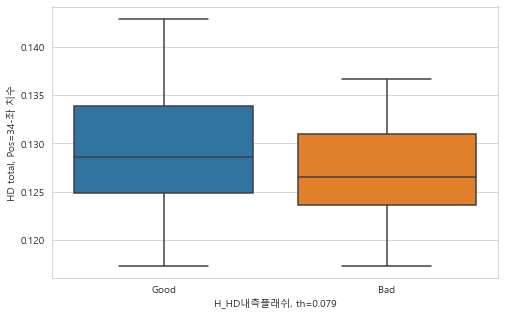

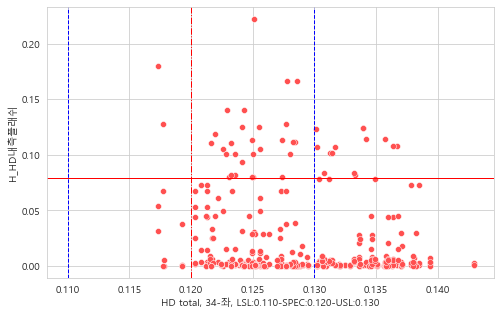

In [933]:
get_box_plot_with_thresh('HD', 'H_HD내측플래쉬', 'd:/data/gb305/box_plots/220323', '34-좌', dict_thresh) #, str_mold_no='P03')

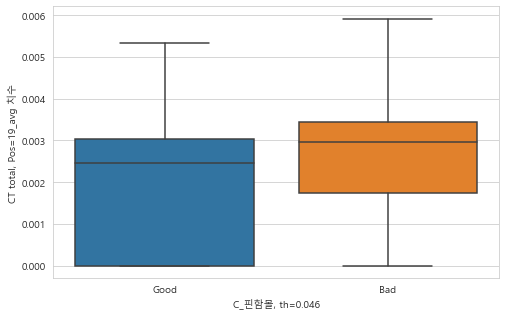

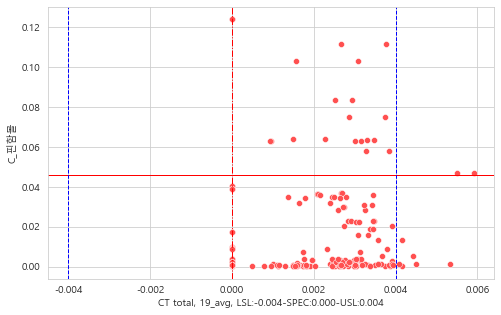

In [934]:
get_box_plot_with_thresh('CT', 'C_핀함몰', 'd:/data/gb305/box_plots/220323', '19', dict_thresh_CT) #, str_mold_no='P03')

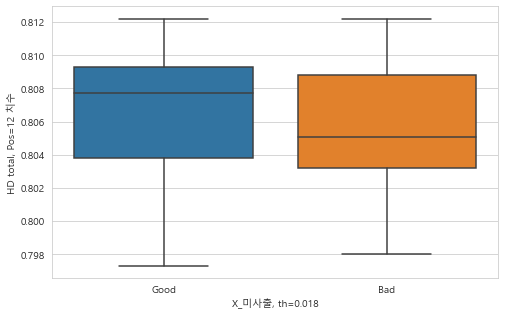

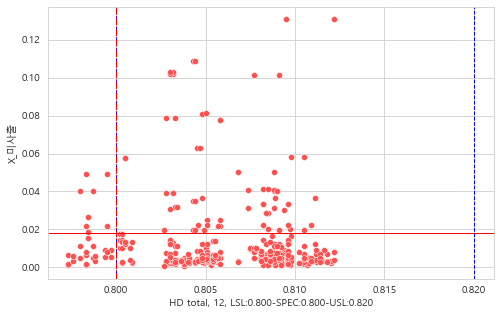

In [935]:
get_box_plot_with_thresh('HD', 'X_미사출', 'd:/data/gb305/box_plots/220323', '12', dict_thresh_HD_) #, str_mold_no='P03')

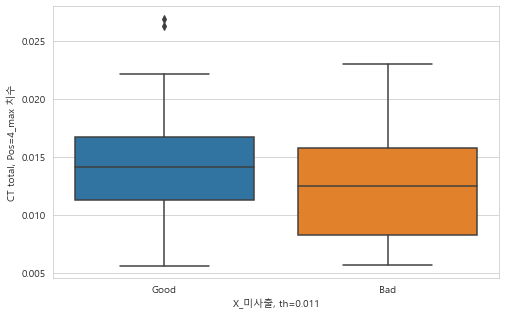

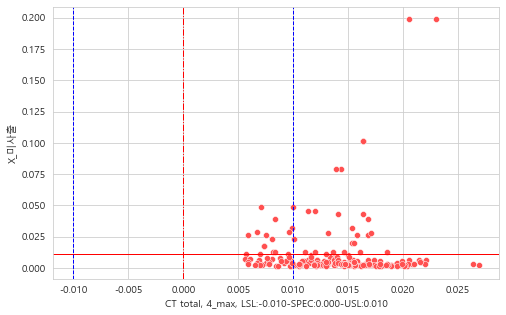

In [936]:
get_box_plot_with_thresh('CT', 'X_미사출', 'd:/data/gb305/box_plots/220323', '4.2', dict_thresh_CT_) #, str_mold_no='P03')

In [937]:
def get_scatter_plot_by_mold_no(str_mold, str_ng, str_column, str_save_path):
    str_default_dir = 'D:\\Data\\GB305'
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    df_spec = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_Spec.xlsx'), engine='openpyxl', index_col=0)

    # Convert column names to string.
    df_target.columns = get_list_string_columns(df_target)
    df_spec.columns = get_list_string_columns(df_spec)

    str_column = str(str_column)

    list_mold_no = df_target['금형번호'].drop_duplicates().sort_values().reset_index(drop=True)

    df_mold = pd.DataFrame()
    for str_mold_no in list_mold_no:
        df_temp = df_target[df_target['금형번호'] == str_mold_no][str_column].reset_index(drop=True)
        df_mold = pd.concat([df_mold, df_temp], axis=1)

    df_mold.columns = list_mold_no.values

    list_str_column = str(str_column).split('.')
    str_readable_column = ''
    if len(list_str_column) > 1:
        if list_str_column[-1] == '1':
            str_readable_column = str(str_column).replace('.1', '_min')
        elif list_str_column[-1] == '2':
            str_readable_column = str(str_column).replace('.2', '_max')
        elif list_str_column[-1] == '3':
            str_readable_column = str(str_column).replace('.3', '_std')
    elif str_mold == 'CT':
        str_readable_column = str(str_column) + '_avg'

    df_mold = df_mold.reset_index(drop=True)

    fig2 = plt.figure(figsize=(8, 5))

    sb.scatterplot(data=df_mold, color=(255/255, 80/255, 80/255))

    # plt.xlim(get_min_max(df_mold[str_column], df_spec[str_column]))

    if len(str_column.split('.')) > 1:
        str_tail = str_column.split('.')[1]
    else:
        str_tail = 'pass'

    if str_tail == '3':
        plt.xlabel(f"{str_mold}, {str_readable_column}")
    else:
        str_spec = str_column.split('.')[0]
        plt.axhline(df_spec[str_spec]['LSL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['USL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['규격'], color='r', linewidth=1, linestyle='dashdot')

        plt.xlabel(f"{str_mold}, {str_readable_column}, LSL:{df_spec['1']['LSL']:.3f}-SPEC:{df_spec[str_spec]['규격']:.3f}-USL:{df_spec[str_spec]['USL']:.3f}")

    plt.ylabel('C_핀함몰')

    os.makedirs(str_save_path, exist_ok=True)
    plt.savefig(os.path.join(str_save_path, f'{str_mold}_molds_{str_readable_column}_scatter.png'), bbox_inches='tight')
    plt.show()

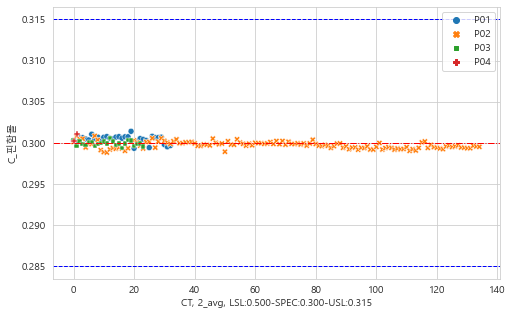

In [938]:
get_scatter_plot_by_mold_no('CT', 'C_핀함몰', '2', 'd:/data/gb305/box_plots/220323')

In [939]:
def get_scatter_plot_by_error(str_mold, str_ng, str_column, str_save_path):
    str_default_dir = 'D:\\Data\\GB305'
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    df_spec = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_Spec.xlsx'), engine='openpyxl', index_col=0)

    # Convert column names to string.
    df_target.columns = get_list_string_columns(df_target)
    df_spec.columns = get_list_string_columns(df_spec)

    str_column = str(str_column)

    list_str_column = str(str_column).split('.')
    str_readable_column = ''
    if len(list_str_column) > 1:
        if list_str_column[-1] == '1':
            str_readable_column = str(str_column).replace('.1', '_min')
        elif list_str_column[-1] == '2':
            str_readable_column = str(str_column).replace('.2', '_max')
        elif list_str_column[-1] == '3':
            str_readable_column = str(str_column).replace('.3', '_std')
    elif str_mold == 'CT':
        str_readable_column = str(str_column) + '_avg'

    fig2 = plt.figure(figsize=(8, 5))

    sb.scatterplot(data=df_target, x=df_target.index, y=str_column, hue='NG')

    # plt.xlim(get_min_max(df_mold[str_column], df_spec[str_column]))

    if len(str_column.split('.')) > 1:
        str_tail = str_column.split('.')[1]
    else:
        str_tail = 'pass'

    if str_tail == '3':
        plt.xlabel(f"{str_mold}, {str_readable_column}")
    else:
        str_spec = str_column.split('.')[0]
        plt.axhline(df_spec[str_spec]['LSL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['USL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['규격'], color='r', linewidth=1, linestyle='dashdot')

        plt.xlabel(f"{str_mold}, {str_readable_column}, LSL:{df_spec['1']['LSL']:.3f}-SPEC:{df_spec[str_spec]['규격']:.3f}-USL:{df_spec[str_spec]['USL']:.3f}")

    plt.ylabel('C_핀함몰')

    os.makedirs(str_save_path, exist_ok=True)
    plt.savefig(os.path.join(str_save_path, f'{str_mold}_{str_ng}_{str_readable_column}_scatter.png'), bbox_inches='tight')
    plt.show()

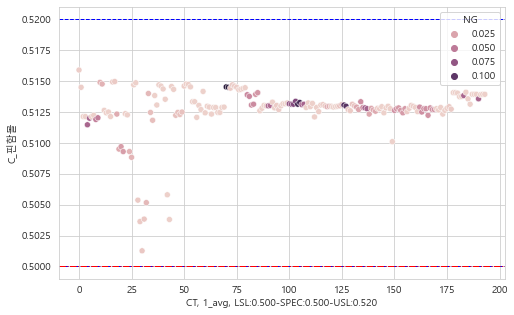

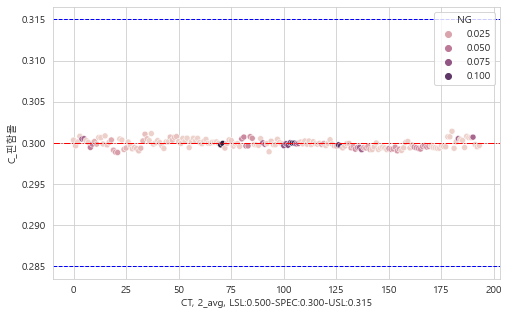

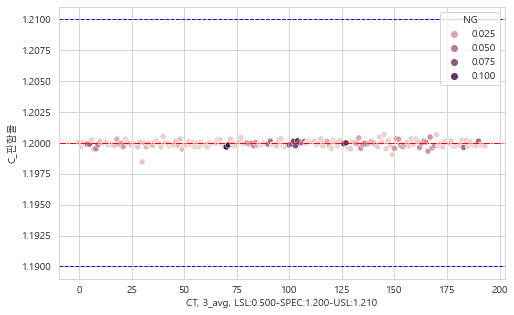

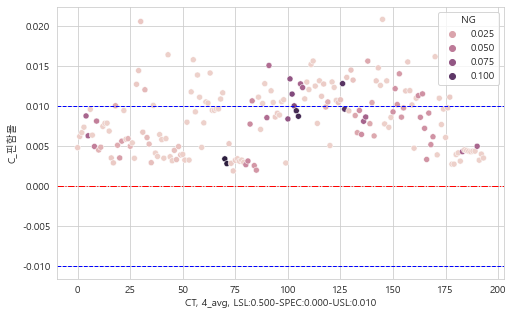

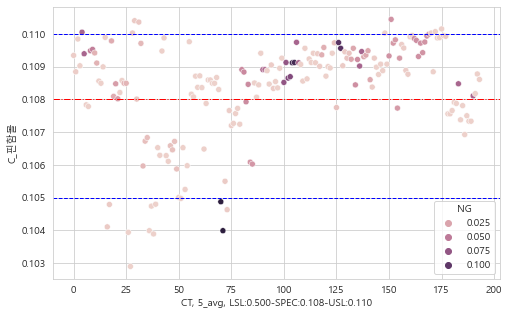

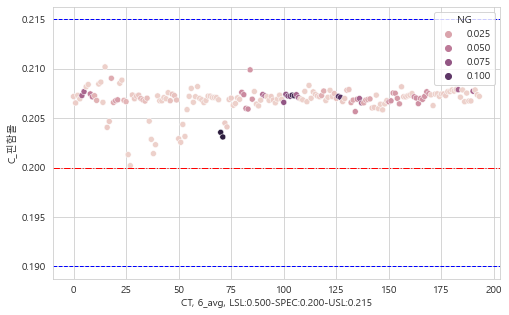

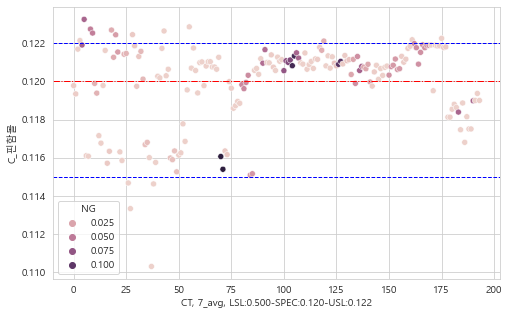

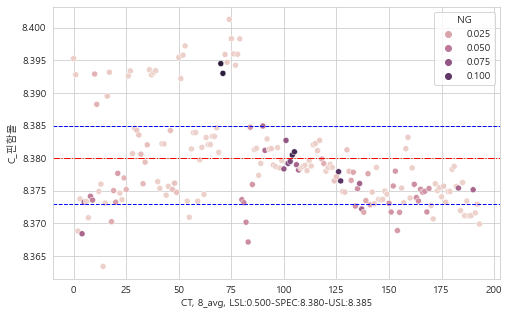

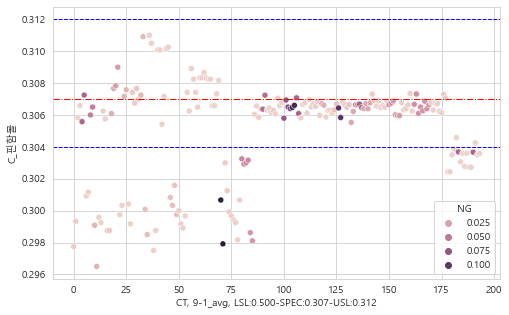

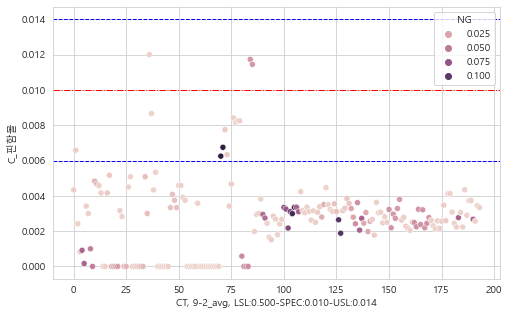

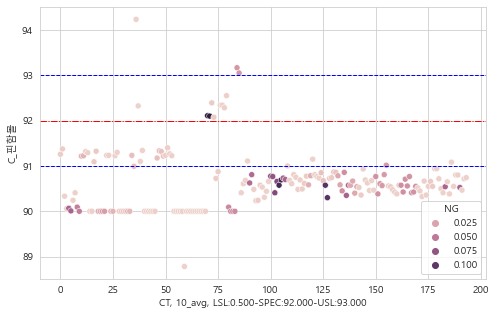

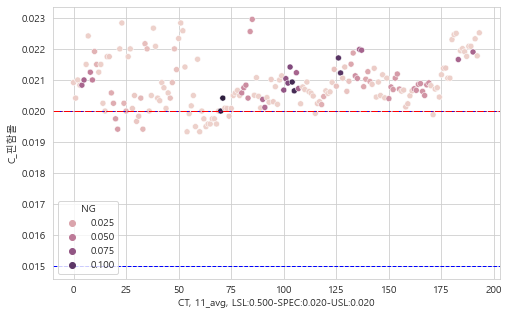

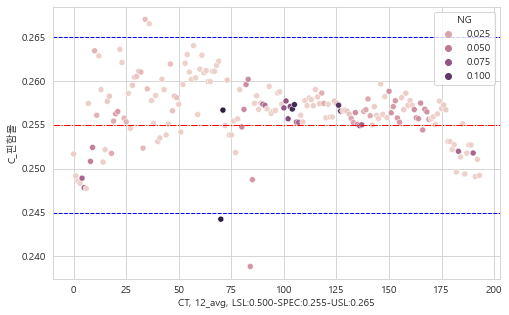

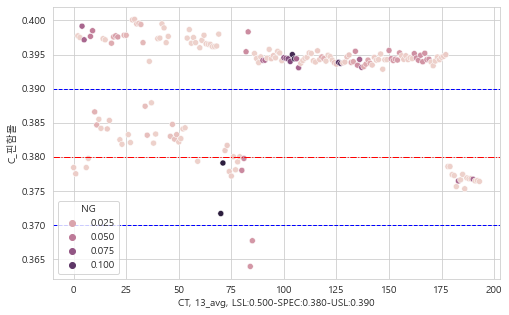

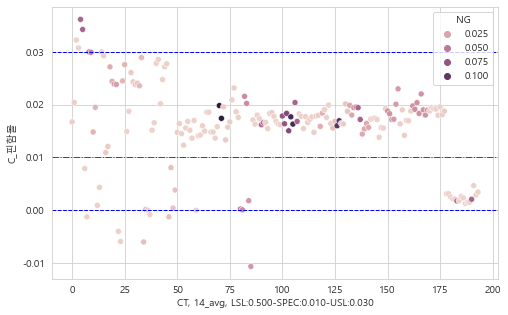

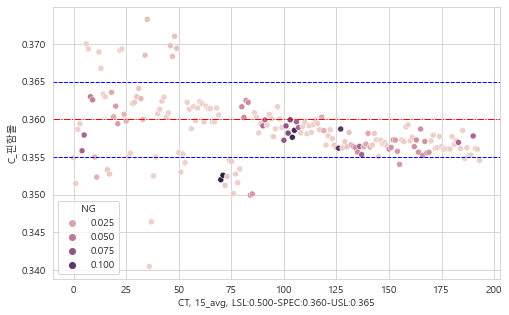

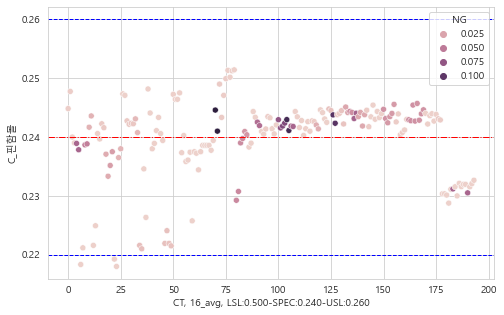

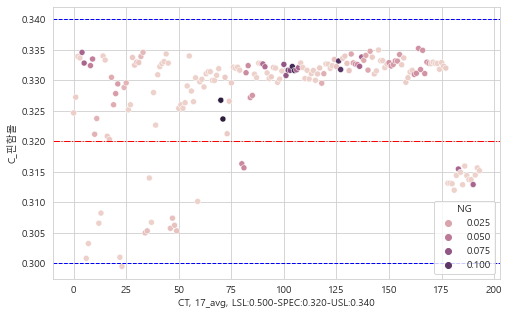

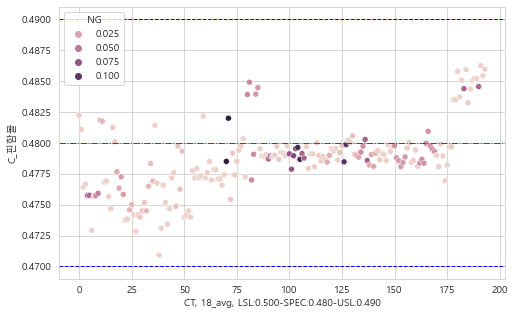

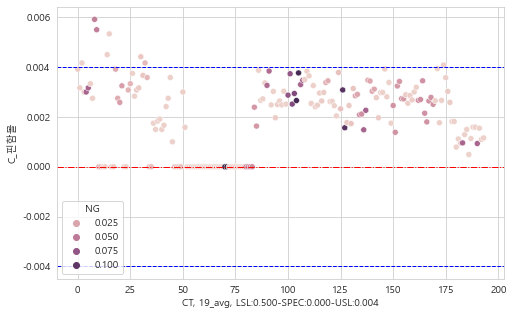

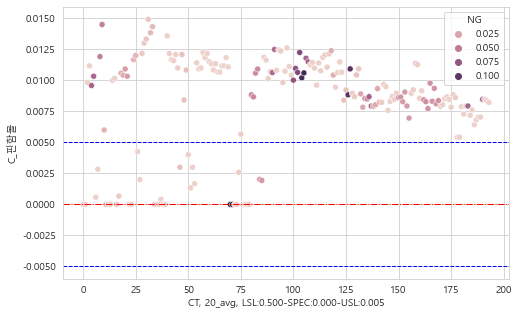

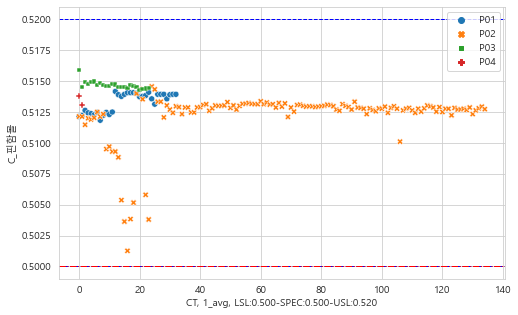

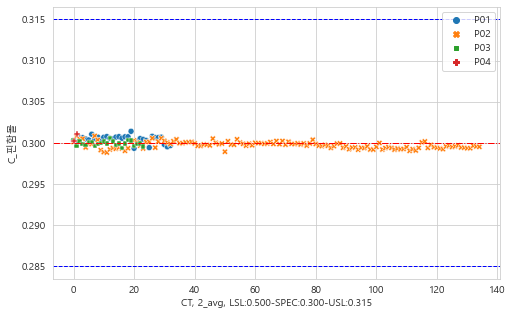

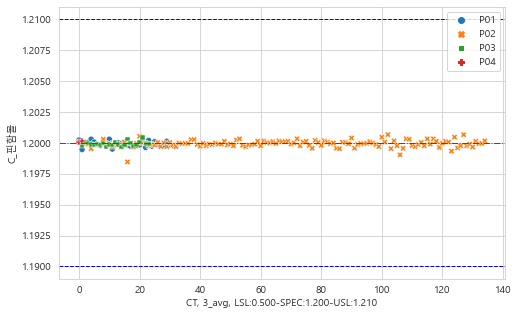

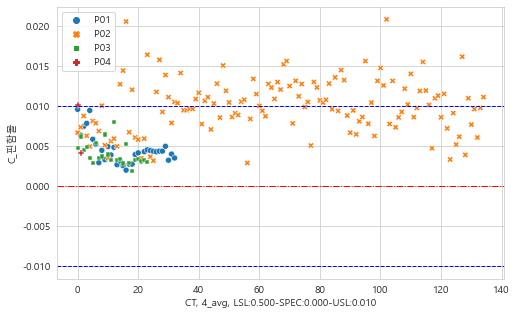

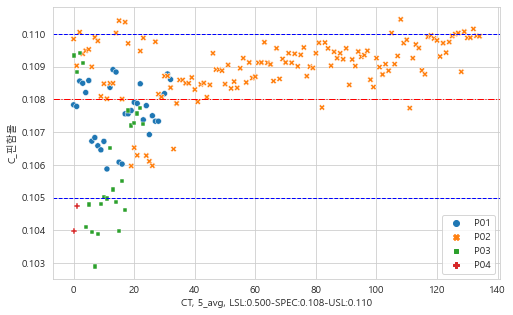

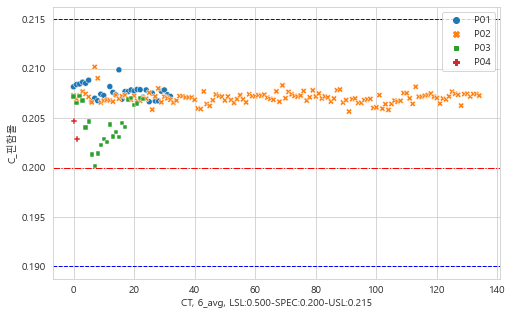

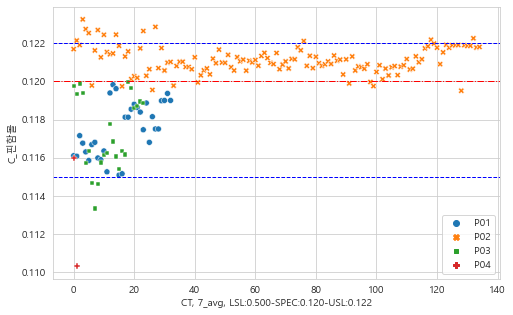

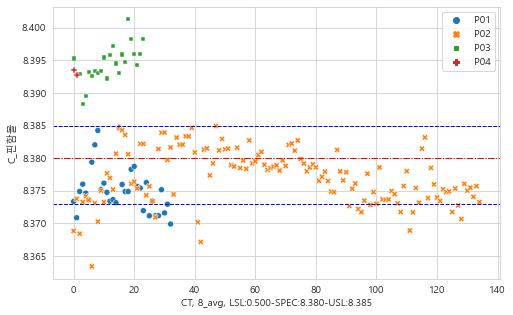

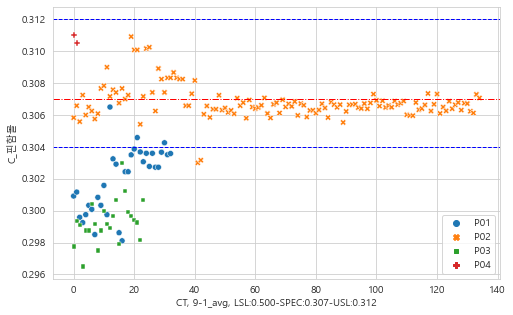

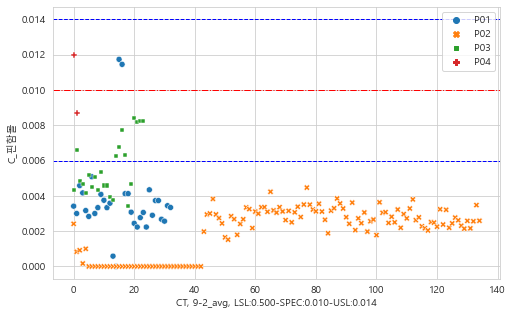

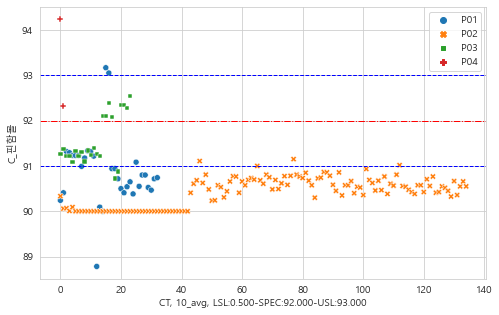

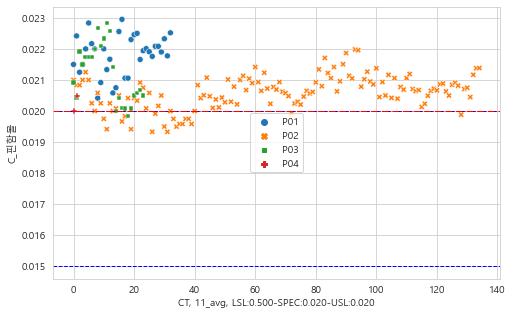

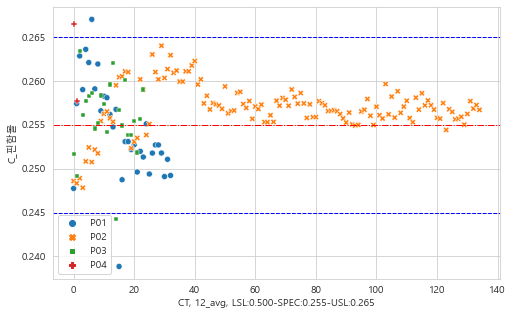

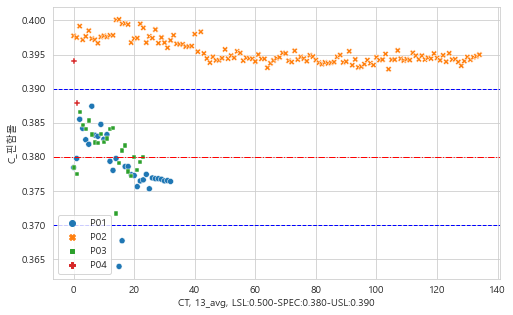

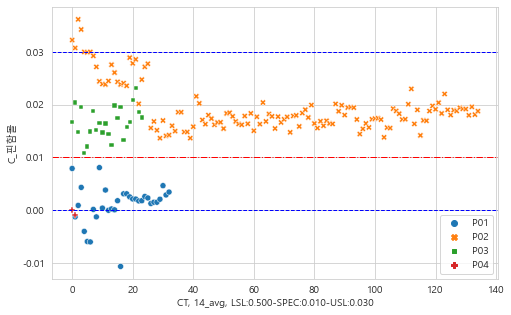

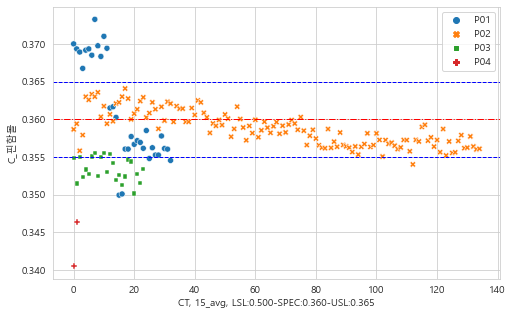

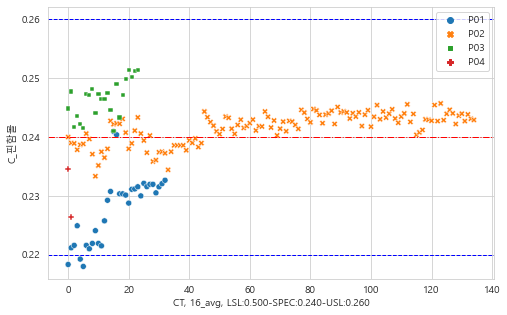

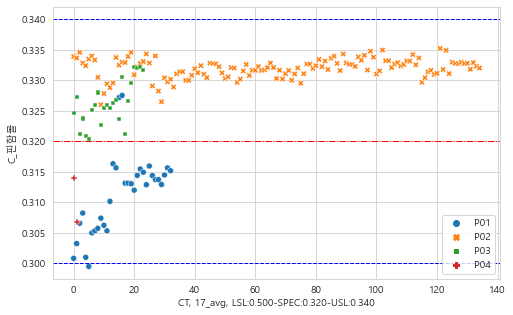

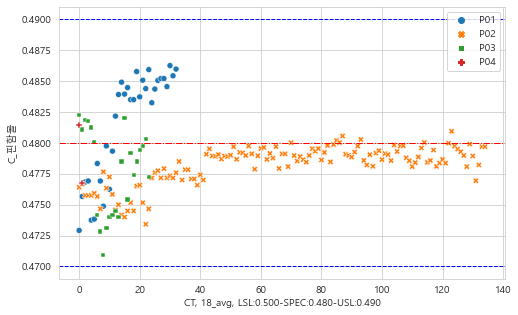

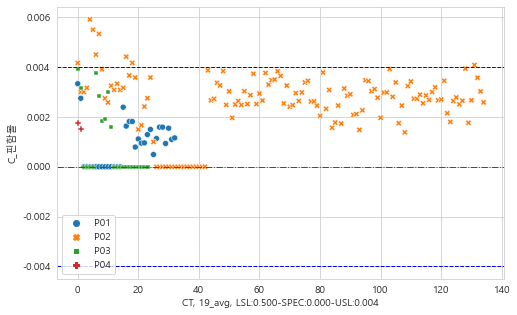

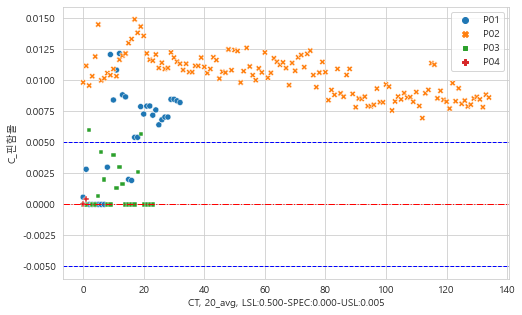

In [940]:
str_mold = 'CT'
str_default_dir = 'D:\\Data\\GB305'
str_measure_path = os.path.join(str_default_dir, 'Measure')
df_spec = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_Spec.xlsx'), engine='openpyxl', index_col=0)

for str_pos in list(df_spec.columns):
    get_scatter_plot_by_error(str_mold, 'C_핀함몰', str(str_pos), 'd:/data/gb305/box_plots/220323')

for str_pos in list(df_spec.columns):
    get_scatter_plot_by_mold_no(str_mold, 'C_핀함몰', str(str_pos), 'd:/data/gb305/box_plots/220323')

In [941]:
def get_scatter_plot_by_mold_no_and_error(str_mold, str_ng, str_column, str_mold_no, str_save_path):
    str_default_dir = 'D:\\Data\\GB305'
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    df_spec = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_Spec.xlsx'), engine='openpyxl', index_col=0)

    # Convert column names to string.
    df_target.columns = get_list_string_columns(df_target)
    df_spec.columns = get_list_string_columns(df_spec)

    str_column = str(str_column)

    list_str_column = str(str_column).split('.')
    str_readable_column = str_column
    if len(list_str_column) > 1:
        if list_str_column[-1] == '1':
            str_readable_column = str(str_column).replace('.1', '_min')
        elif list_str_column[-1] == '2':
            str_readable_column = str(str_column).replace('.2', '_max')
        elif list_str_column[-1] == '3':
            str_readable_column = str(str_column).replace('.3', '_std')
    elif str_mold == 'CT':
        str_readable_column = str(str_column) + '_avg'

    df_target = df_target[df_target['금형번호'] == str_mold_no]

    fig2 = plt.figure(figsize=(8, 5))

    sb.scatterplot(data=df_target, x=df_target.index, y=str_column, hue='NG')

    # plt.xlim(get_min_max(df_mold[str_column], df_spec[str_column]))

    if len(str_column.split('.')) > 1:
        str_tail = str_column.split('.')[1]
    else:
        str_tail = 'pass'

    if str_tail == '3':
        plt.ylabel(f"{str_mold}, {str_readable_column}")
    else:
        str_spec = str_column.split('.')[0]
        plt.axhline(df_spec[str_spec]['LSL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['USL'], color='b', linewidth=1, linestyle='dashed')
        plt.axhline(df_spec[str_spec]['규격'], color='r', linewidth=1, linestyle='dashdot')

        plt.ylabel(f"{str_mold} {str_mold_no}, {str_readable_column}, LSL:{df_spec['1']['LSL']:.3f}-SPEC:{df_spec[str_spec]['규격']:.3f}-USL:{df_spec[str_spec]['USL']:.3f}")

    plt.xlabel('C_핀함몰')
    os.makedirs(str_save_path, exist_ok=True)
    plt.savefig(os.path.join(str_save_path, f'{str_mold}_{str_mold_no}_{str_ng}_{str_readable_column}_scatter.png'), bbox_inches='tight')
    plt.show()

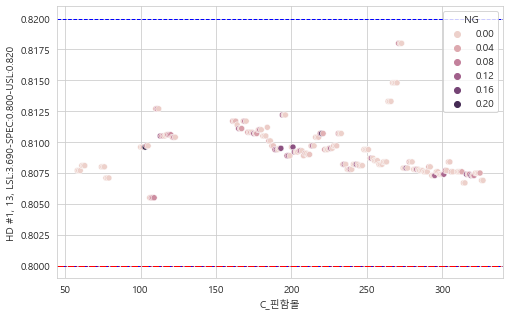

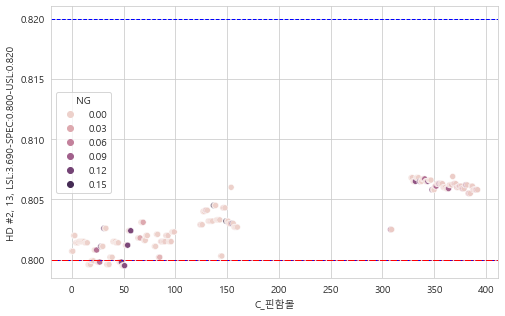

In [942]:
list_mold_no = ['#1', '#2']
for str_mold_no in list_mold_no:
    get_scatter_plot_by_mold_no_and_error('HD', 'H_HD내측플래쉬', '13', str_mold_no, 'd:/data/gb305/box_plots/220323')


In [943]:
def get_3d_graph(str_mold, str_ng, str_1st_pos, str_2nd_pos, str_save_path):
    dict_index = {}
    str_default_dir = 'D:\\Data\\GB305'
    str_measure_path = os.path.join(str_default_dir, 'Measure')
    df_target = pd.read_excel(os.path.join(str_measure_path, f'{str_mold}_inout_{str_ng}.xlsx'), engine='openpyxl', index_col=0)
    df_target.columns = get_list_string_columns(df_target)

    x = df_target[str_1st_pos]
    y = df_target[str_2nd_pos]
    z = df_target['NG']

    if x.dtype == object:
        x, dict_index[0] = x.factorize(sort=True)

    if y.dtype == object:
        y, dict_index[1] = y.factorize(sort=True)

    if z.dtype == object:
        z, dict_index[2] = z.factorize(sort=True)

    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)

    vmin = z.min() - (z.max() - z.min()) / 5

    f = ax.scatter(x, y, z, s=2, c=z, cmap='autumn_r', vmin=vmin)

    if 0 in dict_index.keys():
        ax.set_xlabel(str(list(dict_index[0])))
    else:
        ax.set_xlabel(str_1st_pos)

    if 1 in dict_index.keys():
        ax.set_ylabel(str(list(dict_index[1])))
    else:
        ax.set_ylabel(str_2nd_pos)

    if 2 in dict_index.keys():
        ax.set_zlabel(str(list(dict_index[2])))
    else:
        ax.set_zlabel(str_ng)

    # ax.set(zlim=(0, 0.4))
    # ax.view_init(rot1, rot2)
    # print("rot1:%d" % rot1, "rot2:%d" % rot2)

    os.makedirs(str_save_path, exist_ok=True)
    str_file_path = os.path.join(str_save_path, f'{str_ng}_{str_1st_pos}_{str_2nd_pos}.png')
    str_file_path = str_file_path.replace('/', '')

    fig.colorbar(f, shrink=0.5, location='left')

    plt.savefig(str_file_path, bbox_inches='tight')

    plt.show()

    return dict_index


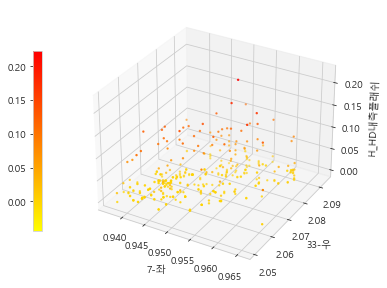

{}

In [944]:
get_3d_graph('HD', 'H_HD내측플래쉬', '7-좌', '33-우', 'd:\\data\\gb305\\box_plots\\220323')

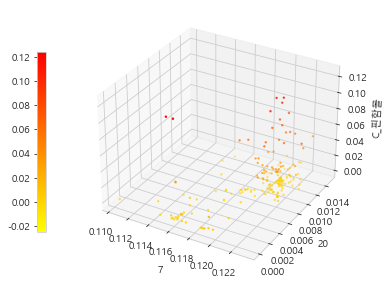

{}

In [945]:
get_3d_graph('CT', 'C_핀함몰', '7', '20', 'd:\\data\\gb305\\box_plots\\220323')

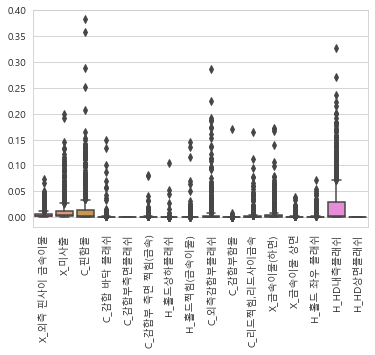

In [946]:
sb.boxplot(data=df_raw[df_raw.columns[idx_ng_rate]])
plt.xticks(rotation=90)
plt.savefig(f'{str_default_dir}\\ng_category_boxplot.png', bbox_inches='tight')
plt.show()

In [947]:
def get_df_for_graph(_df_raw, str_target_env, str_target_ng, str_save_path=None):
    df_graph = pd.DataFrame()
    df_ng_env = _df_raw[[str_target_ng, str_target_env]]

    for value in df_ng_env[str_target_env].drop_duplicates().values:
        df_temp = pd.DataFrame()
        df_temp[value] = df_ng_env[df_ng_env[str_target_env] == value][str_target_ng].reset_index(drop=True)
        df_graph = pd.concat([df_graph, df_temp], axis=1)

    sb.boxplot(data=df_graph, order=list(df_graph.columns.sort_values()))
    if str_target_env == '작업자':
        plt.xticks(rotation=90)

    plt.ylabel(f'{str_target_ng} 불량률')
    plt.xlabel(str_target_env)
    # plt.boxplot(df_graph)
    if str_save_path is not None:
        str_save_path = str_save_path.replace('/', '')
        plt.savefig(str_save_path, bbox_inches='tight')
    plt.show()

# df_graph['#1'] = df_n_inj[df_n_inj['HD금형번호'] == '#1']['X_미사출'].reset_index(drop=True)
# df_graph['#2'] = df_n_inj[df_n_inj['HD금형번호'] == '#2']['X_미사출'].reset_index(drop=True)

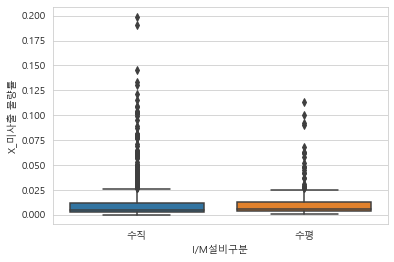

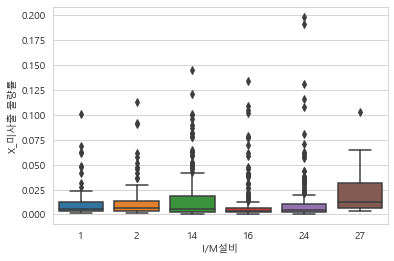

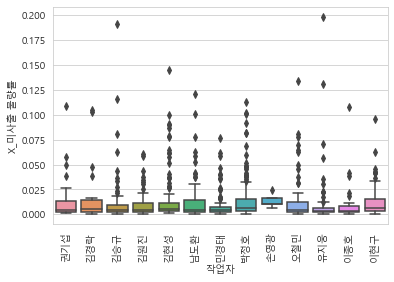

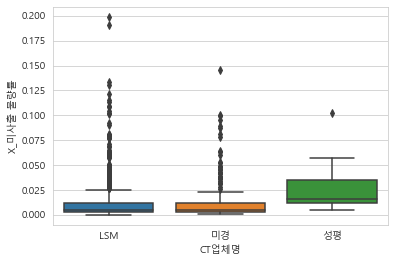

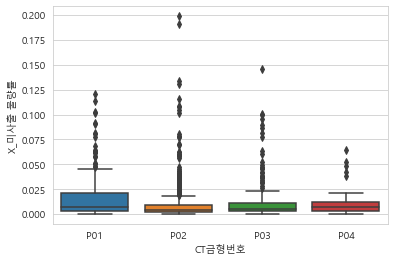

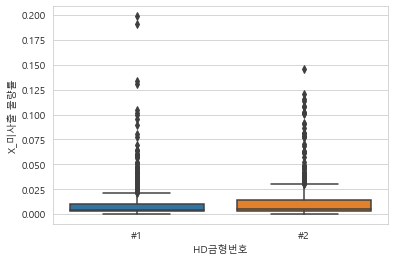

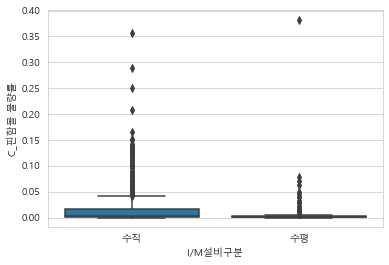

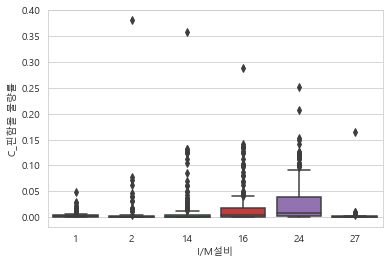

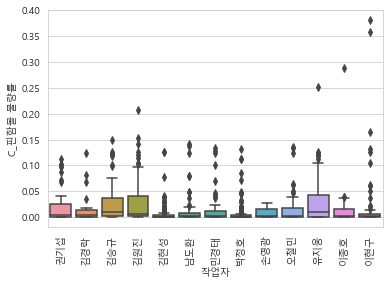

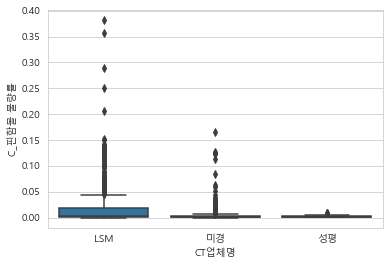

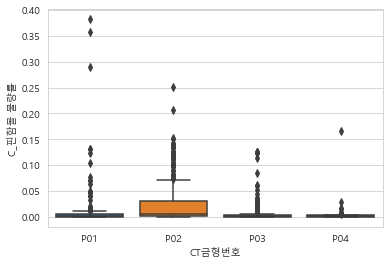

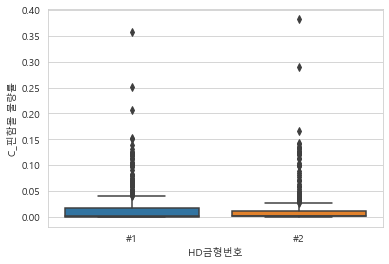

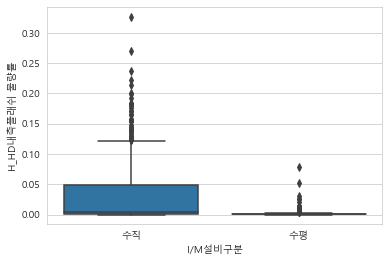

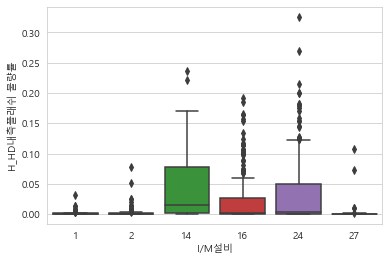

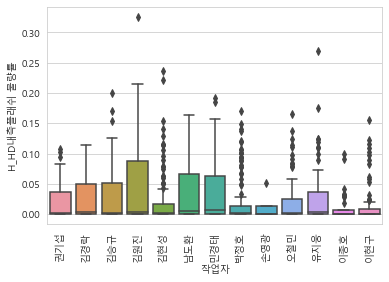

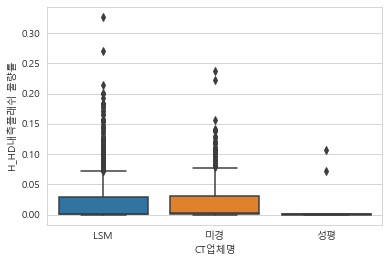

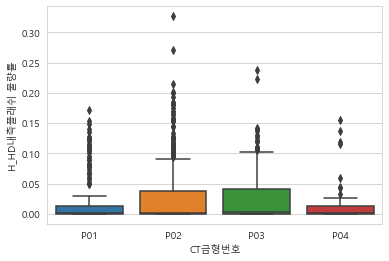

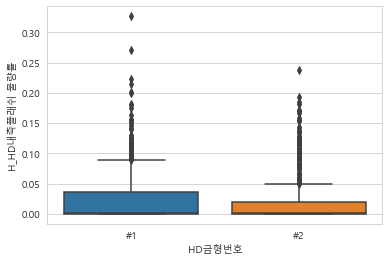

In [948]:
list_env = ['I/M설비구분', 'I/M설비', '작업자', 'CT업체명', 'CT금형번호', 'HD금형번호']
list_ng = ['X_미사출', 'C_핀함몰', 'H_HD내측플래쉬']

for ng in list_ng:
    for env in list_env:
        str_save_fig_path = f'{str_default_dir}\\{ng}_{env}.png'
        get_df_for_graph(df_raw, env, ng, str_save_fig_path)
# get_df_for_graph(df_raw, 'HD금형번호', 'X_미사출')
# get_df_for_graph(df_raw, 'I/M설비', 'X_미사출')
# get_df_for_graph(df_raw, '작업자', 'X_미사출')
# get_df_for_graph(df_raw, 'I/M설비구분', 'X_미사출')
# get_df_for_graph(df_raw, 'CT금형번호', 'X_미사출')

In [949]:
# def vertical_mean_line_survived(x, **kwargs):
#     ls = {"0":"-","1":"--"}
#     plt.axvline(x.mean(), linestyle =ls[kwargs.get("label","0")],
#                 color = kwargs.get("color", "g"))
#     txkw = dict(size=12, color = kwargs.get("color", "g"), rotation=90)
#     tx = "mean: {:.2f}, std: {:.2f}".format(x.mean(),x.std())
#     plt.text(x.mean()+1, 0.052, tx, **txkw)

def get_displot(_df_raw, str_target_env, str_target_ng, str_save_path=None):
    df_graph = pd.DataFrame()
    df_ng_env = _df_raw[[str_target_ng, str_target_env]]

    for value in df_ng_env[str_target_env].drop_duplicates().values:
        df_temp = pd.DataFrame()
        df_temp[value] = df_ng_env[df_ng_env[str_target_env] == value][str_target_ng].reset_index(drop=True)
        df_graph = pd.concat([df_graph, df_temp], axis=1)

    df_graph = df_graph[list(df_graph.columns.sort_values())]

    sb.displot(df_graph, kind='kde', fill=True)

    plt.xlim([0, 0.05])
    # plt.xlabel(str_target_ng)

    if str_save_path is not None:
        str_save_path = str_save_path.replace('/', '')
        plt.savefig(str_save_path, bbox_inches='tight')
    plt.show()

def get_distplot(_df_raw, str_target_env, str_target_ng, str_save_path=None):
    df_graph = pd.DataFrame()
    df_ng_env = _df_raw[[str_target_ng, str_target_env]]

    for value in df_ng_env[str_target_env].drop_duplicates().values:
        df_temp = pd.DataFrame()
        df_temp[value] = df_ng_env[df_ng_env[str_target_env] == value][str_target_ng].reset_index(drop=True)
        df_graph = pd.concat([df_graph, df_temp], axis=1)

    df_graph = df_graph[list(df_graph.columns.sort_values())]

    dict_line = {}
    f, ax = plt.subplots()
    ax2 = ax.twinx()
    ax2.axis('off')
    for column, color in zip(df_graph.columns, sb.color_palette('tab10', len(df_graph.columns))):
        sb.distplot(df_graph[column], kde=True, hist=False, color=color, axlabel=False)

    for column, color in zip(df_graph.columns, sb.color_palette('tab10', len(df_graph.columns))):
        dict_line[column] = plt.axvline(df_graph[column].mean(), color=color)

    list_legend = []

    for name in list(df_graph.columns):
        list_legend.append(f'{name}, m:{df_graph[name].mean():.3f}, s:{df_graph[name].std():.3f}')

    plt.legend(dict_line.values(), list_legend)
    plt.xlim([0, 0.1])

    if str_save_path is not None:
        str_save_path = str_save_path.replace('/', '')
        plt.savefig(str_save_path, bbox_inches='tight')

    plt.show()

d:\venv\dataanalysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
d:\venv\dataanalysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
d:\venv\dataanalysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

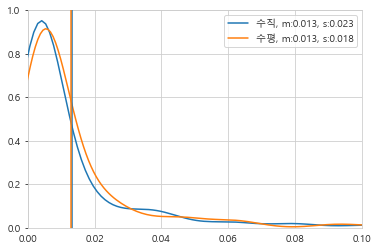

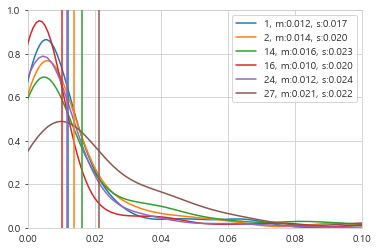

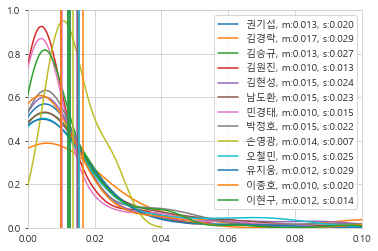

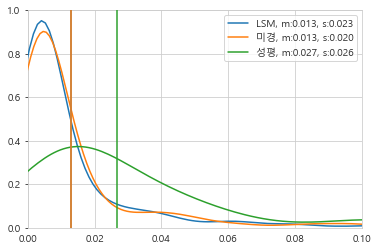

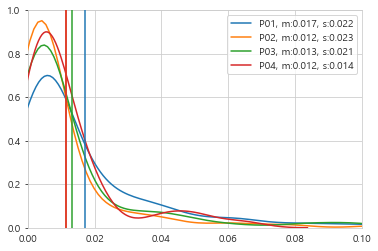

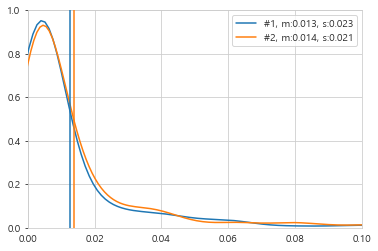

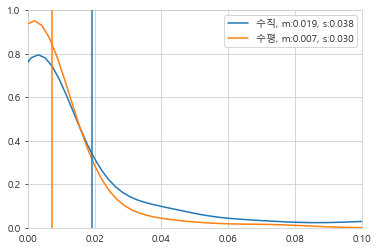

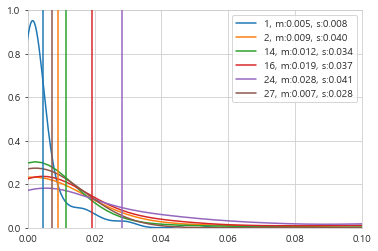

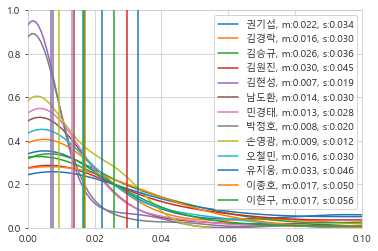

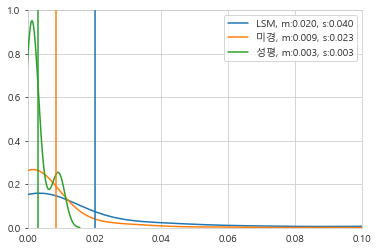

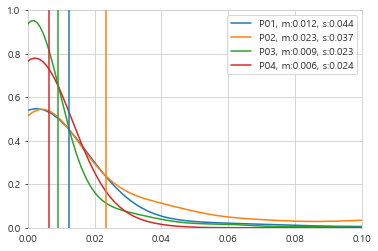

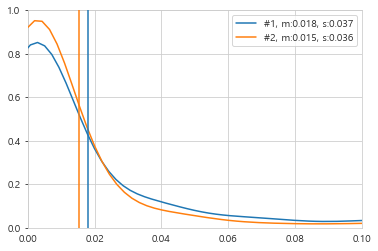

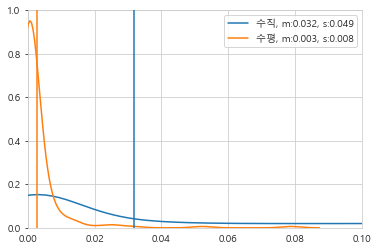

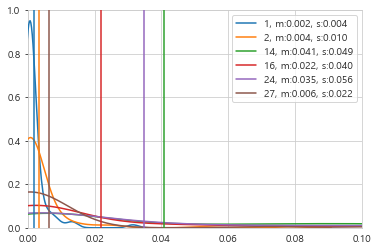

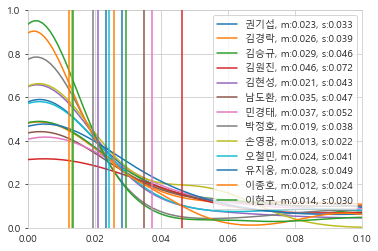

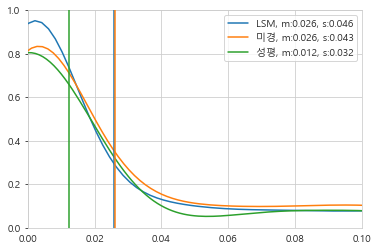

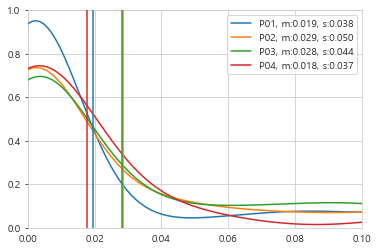

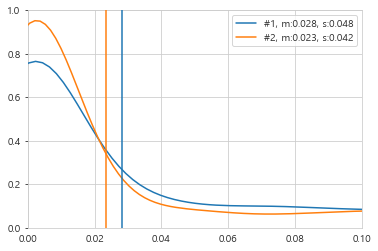

In [950]:
for ng in list_ng:
    for env in list_env:
        str_save_fig_path = f'{str_default_dir}\\{ng}_{env}_distplot.png'
        # str_save_fig_path = None
        get_distplot(df_raw, env, ng, str_save_fig_path)

In [951]:
str_target_ng = 'X_미사출'

str_1st_var = 'CT금형번호'
str_2nd_var = 'HD금형번호'

In [952]:
df_temp = df_raw[[str_target_ng, str_1st_var, str_2nd_var]]

In [953]:
df_time_series = df_raw[['검사일자', '검사시각', 'I/M설비', 'X_미사출', 'C_핀함몰', 'H_HD내측플래쉬', 'CT금형번호', 'HD금형번호']]

In [954]:
df_time_series['DateTime'] = pd.to_datetime(df_time_series['검사일자'].astype(str) + ' ' + df_time_series['검사시각'].astype(str))
df_time_series = df_time_series.sort_values(by='DateTime')
df_time_series

d:\venv\dataanalysis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,검사일자,검사시각,I/M설비,X_미사출,C_핀함몰,H_HD내측플래쉬,CT금형번호,HD금형번호,DateTime
0,2021-12-03,01:19:39,14,0.005678,0.002865,0.001094,P03,#2,2021-12-03 01:19:39
1,2021-12-03,03:31:22,24,0.009066,0.000405,0.000304,P02,#2,2021-12-03 03:31:22
2,2021-12-03,06:26:15,14,0.002527,0.005155,0.000657,P03,#2,2021-12-03 06:26:15
4,2021-12-03,08:04:33,27,0.013162,0.000969,0.000663,P01,#2,2021-12-03 08:04:33
3,2021-12-03,09:19:58,16,0.010049,0.063163,0.004153,P02,#2,2021-12-03 09:19:58
...,...,...,...,...,...,...,...,...,...
897,2022-02-28,04:56:37,14,0.006014,0.000308,0.019378,P03,#1,2022-02-28 04:56:37
898,2022-02-28,10:15:41,14,0.006210,0.000300,0.004908,P01,#1,2022-02-28 10:15:41
899,2022-02-28,11:46:08,24,0.004113,0.000771,0.101948,P03,#2,2022-02-28 11:46:08
900,2022-02-28,15:38:16,2,0.008748,0.001207,0.000503,P03,#1,2022-02-28 15:38:16


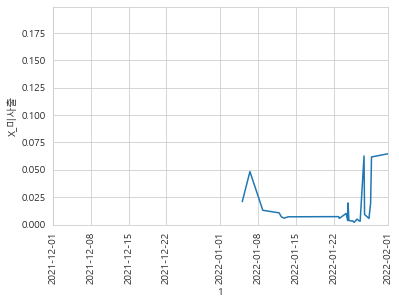

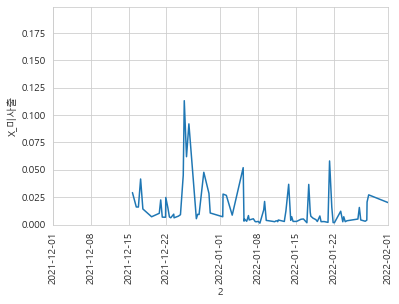

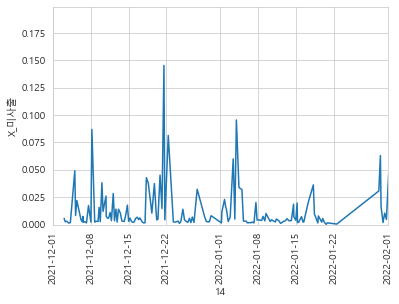

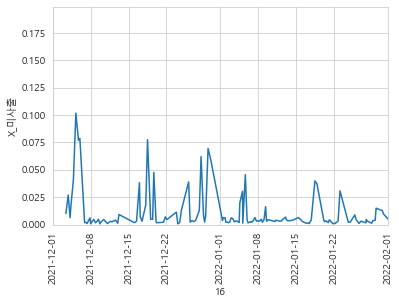

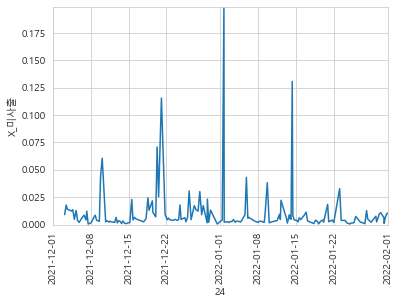

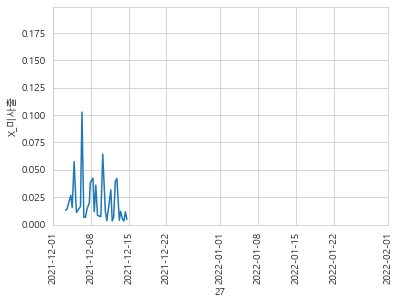

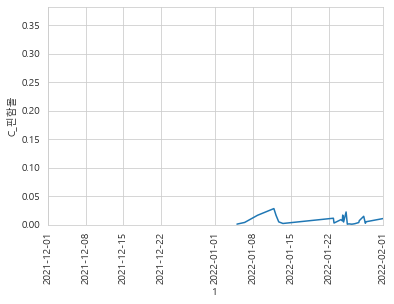

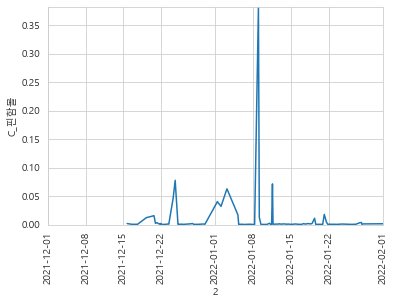

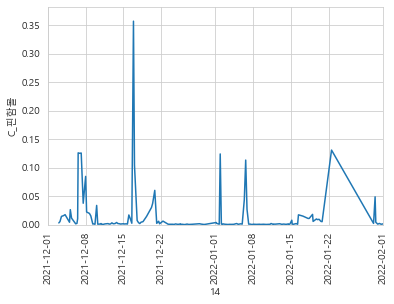

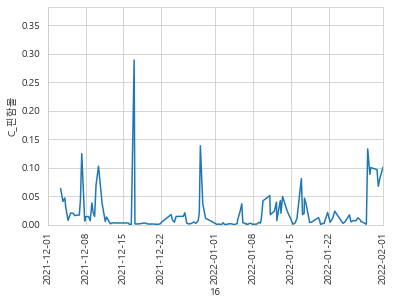

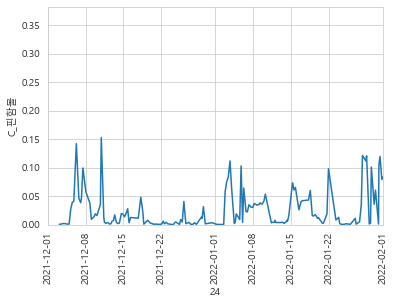

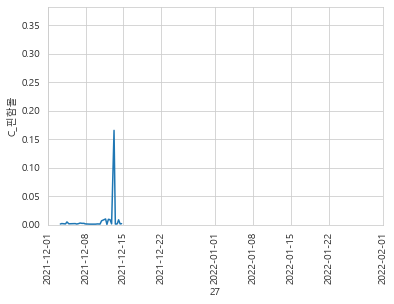

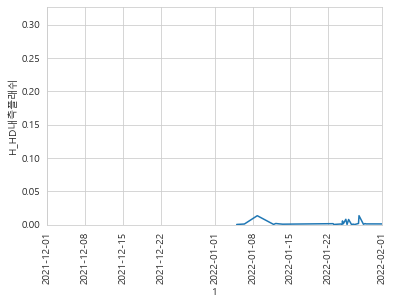

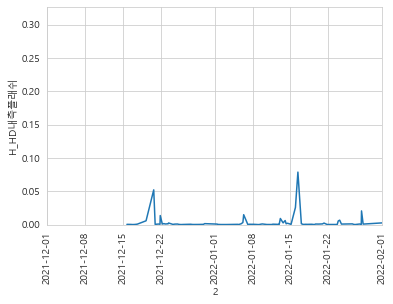

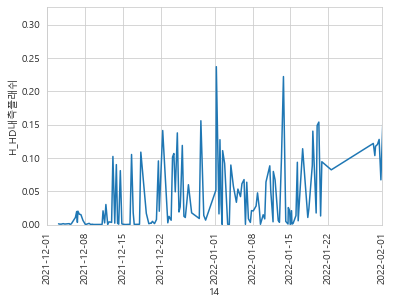

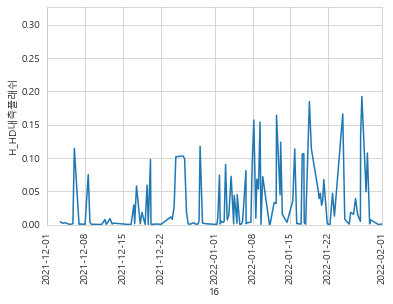

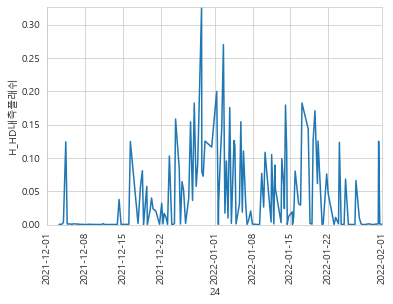

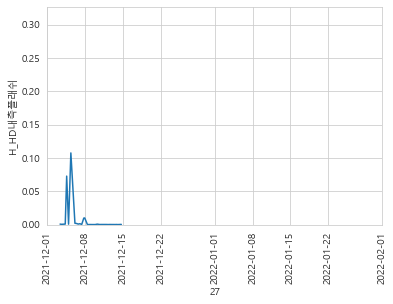

In [955]:
str_target_env = 'I/M설비'
list_im_idx = df_time_series[str_target_env].sort_values().drop_duplicates()
list_ng = ['X_미사출', 'C_핀함몰', 'H_HD내측플래쉬']

for str_ng in list_ng:
    ymax = df_time_series[str_ng].max()
    for im_idx in list_im_idx:
        f, ax = plt.subplots()
        df_temp = df_time_series[df_time_series[str_target_env] == im_idx]
        sb.lineplot(x='DateTime', y=str_ng, data=df_temp)
        plt.xlim([pd.to_datetime('2021-12-01 00:00:00'), pd.to_datetime('2022-02-01 00:00:00')])
        plt.ylim([0, ymax])
        plt.xticks(rotation=90)
        ax.set_xlabel(f'{im_idx}')
        plt.savefig(f'D:/Data/GB305/TimeSeries_{str_ng}_{im_idx}.png', bbox_inches='tight')
        plt.show()